<a href="https://colab.research.google.com/github/Kryptera-K/BBY-MACD-Signal-Dominance-with-QQE-Momentum-Strategy/blob/main/BBY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "BBY"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("BBY_clean.csv", index=False)
df

/tmp/ipython-input-2862564544.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,14.170569,14.201240,13.250402,14.170569,19442925
2000-01-04,14.078550,14.385272,13.495778,13.925189,11525625
2000-01-05,13.986528,14.323924,12.882329,13.986528,11111625
2000-01-06,13.863837,14.262575,13.587787,13.787156,5968125
2000-01-07,14.293257,14.293257,13.802501,13.863845,5736600
...,...,...,...,...,...
2025-12-11,73.992889,74.812074,72.867748,73.183577,3877600
2025-12-12,72.502571,75.029203,72.305181,74.318594,3328500
2025-12-15,71.940002,73.390845,71.782092,73.035536,6194600


In [ ]:
MACD_FAST = 12
MACD_SIGNAL = 9
MACD_SLOW = 26
QQE_FACTOR = 4.236
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5

# -------------------------
# Indicator Functions
# -------------------------

def macd_higher_signal(df):
    df = calculate_macd(df)
    return df["MACD"] > df["Signal"]


def calculate_macd(df, fast=MACD_FAST, slow=MACD_SLOW, signal=MACD_SIGNAL):
    """
    Calculate MACD and Signal lines.
    """
    df = df.copy()
    df["EMA_fast"] = df["Close"].ewm(span=fast, adjust=False).mean()
    df["EMA_slow"] = df["Close"].ewm(span=slow, adjust=False).mean()
    df["MACD"] = df["EMA_fast"] - df["EMA_slow"]
    df["Signal"] = df["MACD"].ewm(span=signal, adjust=False).mean()

    # Previous values for comparisons
    df["MACD_prev"] = df["MACD"].shift(1)
    df["Signal_prev"] = df["Signal"].shift(1)

    return df


def qqe_value1_rising(df, shift=QQE_SHIFT):
    df = calculate_qqe(df)
    return df['QQE_Value1'] > df['QQE_Value1'].shift(shift)


def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    """
    Calculate QQE lines (Value1 & Value2) based on RSI smoothing and ATR-like smoothing.
    """
    df = df.copy()

    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df



# -------------------------
# Entry conditions
# -------------------------

df["MACD_higher_signal"] = macd_higher_signal(df)

# -------------------------
# Exit conditions
# -------------------------

df["QQE_Value1_Rising"] = qqe_value1_rising(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'MACD_higher_signal',
]
exit_conditions = [
    'QQE_Value1_Rising',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

/tmp/ipython-input-524166649.py:55: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')


Start                                2000-01-03 00:00:00
End                                  2025-12-17 00:00:00
Period                                6530 days 00:00:00
Start Value                                     100000.0
End Value                                  962576.129637
Total Return [%]                               862.57613
Benchmark Return [%]                          407.177945
Max Gross Exposure [%]                             100.0
Total Fees Paid                            110523.370392
Max Drawdown [%]                               58.977092
Max Drawdown Duration                 1964 days 00:00:00
Total Trades                                         137
Total Closed Trades                                  137
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   48.175182
Best Trade [%]                                 56.896037
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-12-17 00:00:00
Period                         6530 days 00:00:00
Start Value                              100000.0
End Value                           507177.944775
Total Return [%]                       407.177945
Benchmark Return [%]                   407.177945
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        78.105323
Max Drawdown Duration          2676 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      407177.944775
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-524166649.py:55: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



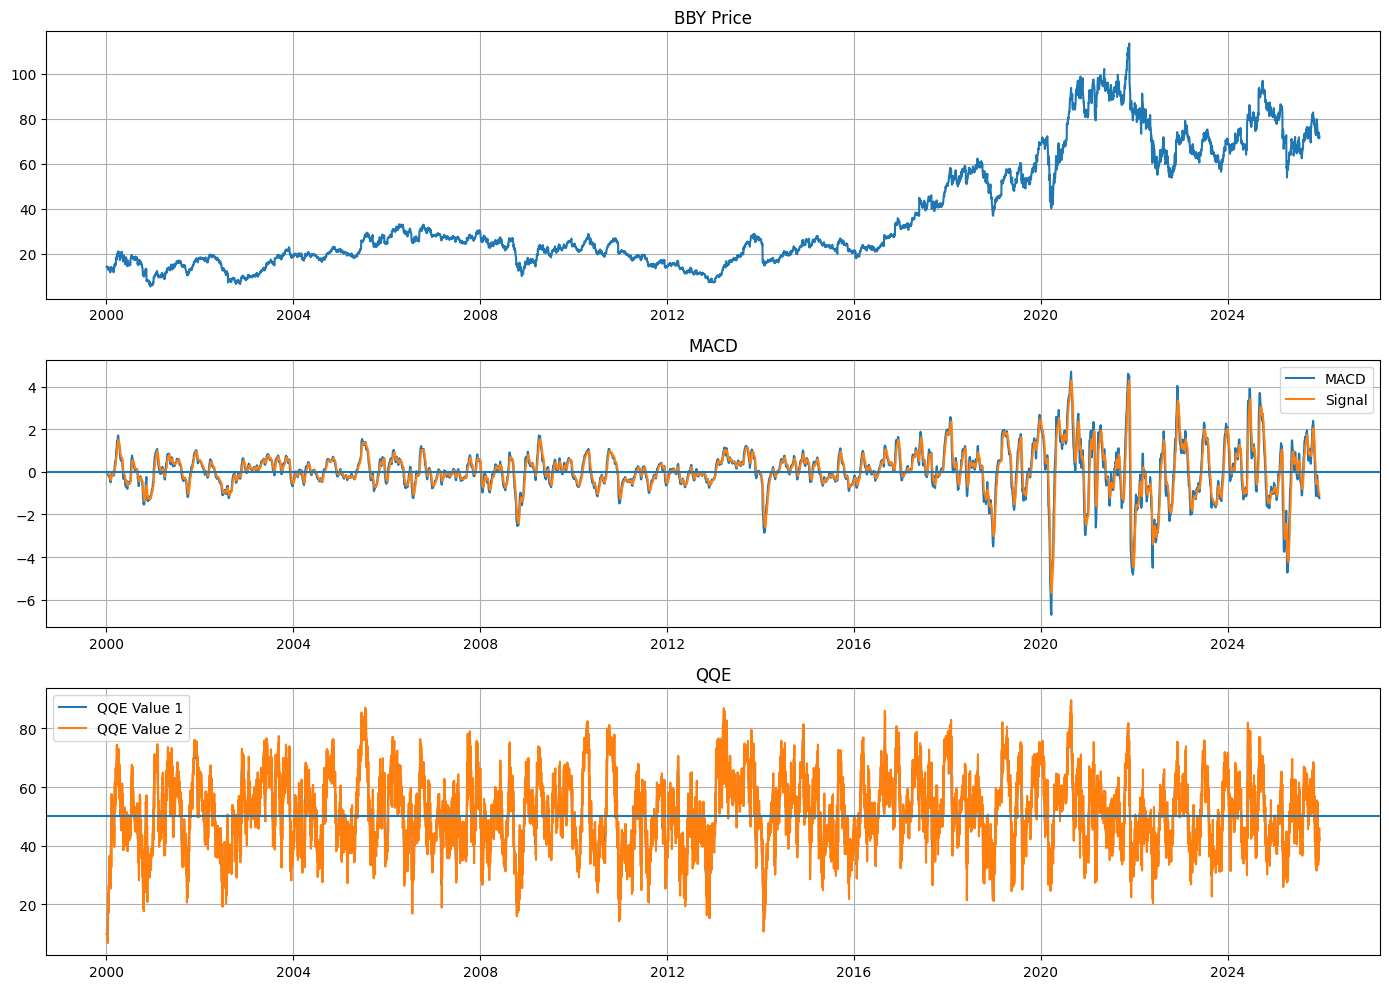

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# Calculate Indicators
# -------------------------
df_ind = df.copy()
df_ind = calculate_macd(df_ind)
df_ind = calculate_qqe(df_ind)

# -------------------------
# Plot
# -------------------------
fig = plt.figure(figsize=(14, 10))

# ===== PRICE =====
ax1 = plt.subplot(3, 1, 1)
ax1.plot(df_ind.index, df_ind["Close"])
ax1.set_title(f"{symbol} Price")
ax1.grid(True)

# ===== MACD =====
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(df_ind.index, df_ind["MACD"], label="MACD")
ax2.plot(df_ind.index, df_ind["Signal"], label="Signal")
ax2.axhline(0)
ax2.set_title("MACD")
ax2.legend()
ax2.grid(True)

# ===== QQE =====
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(df_ind.index, df_ind["QQE_Value1"], label="QQE Value 1")
ax3.plot(df_ind.index, df_ind["QQE_Value2"], label="QQE Value 2")
ax3.axhline(50)
ax3.set_title("QQE")
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()
